First few rows of the original data:
                Preparation  Conversion (%)  Selectivity (%)  Yield (%)  \
0              Impregnation            23.6             20.7        4.9   
1              Impregnation            30.3             24.1        7.3   
2  Deposition–precipitation            37.2             18.3        6.8   
3  Deposition–precipitation            39.6             87.9       34.8   
4          Co-precipitation            47.6              1.2        0.6   

   Ru (wt%)  Cu (wt%)  ZnO (wt%)  NaOH (wt%)  ZnSO₄ (wt%)  AlOOH (wt%)  ...  \
0      2.91      0.18      96.91        0.00          0.0          0.0  ...   
1      1.96      0.12      65.45       32.43          0.0          0.0  ...   
2      1.96      0.11      97.93        0.00          0.0          0.0  ...   
3      1.32      0.08      66.22       32.43          0.0          0.0  ...   
4     20.00      1.26      78.74        0.00          0.0          0.0  ...   

   Reduction temperature (K)  Hydroge

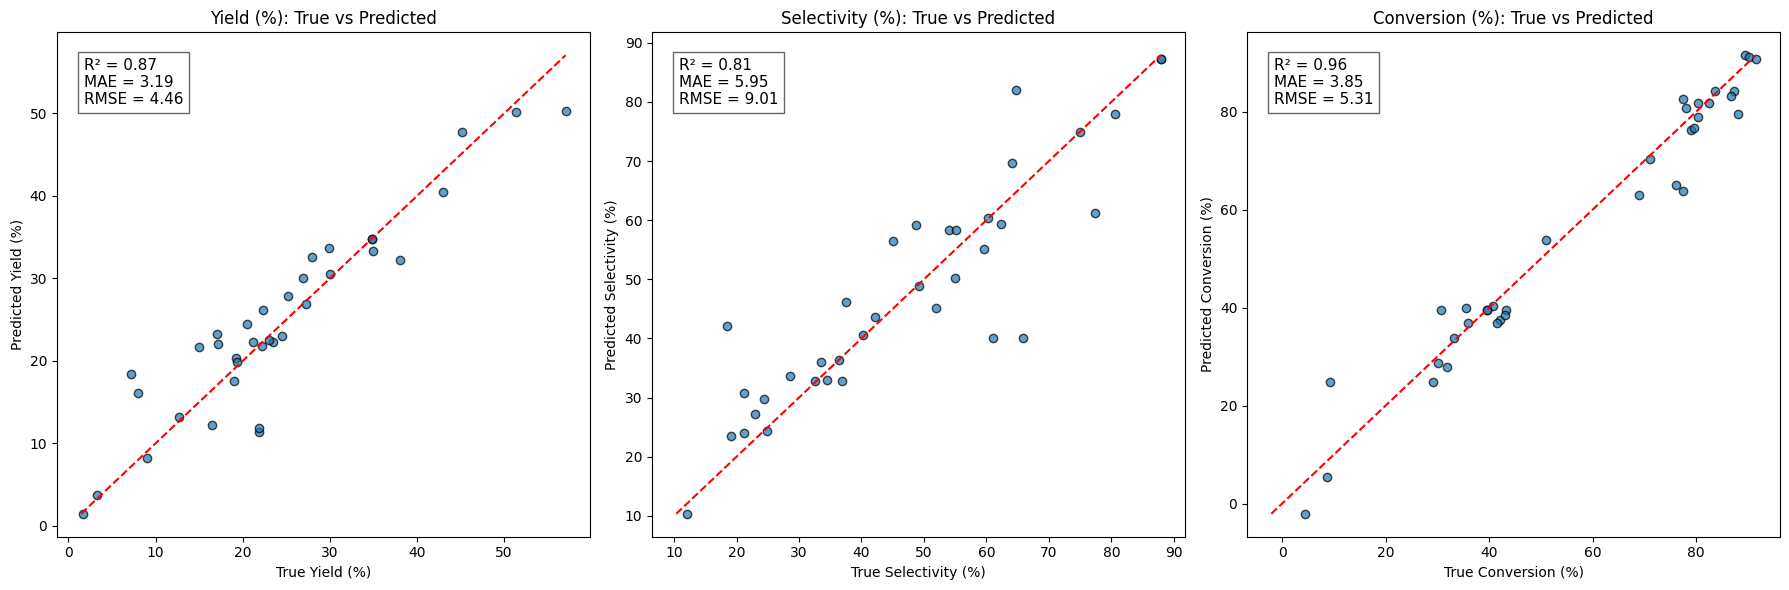


=== SHAP Analysis for Yield (%) ===


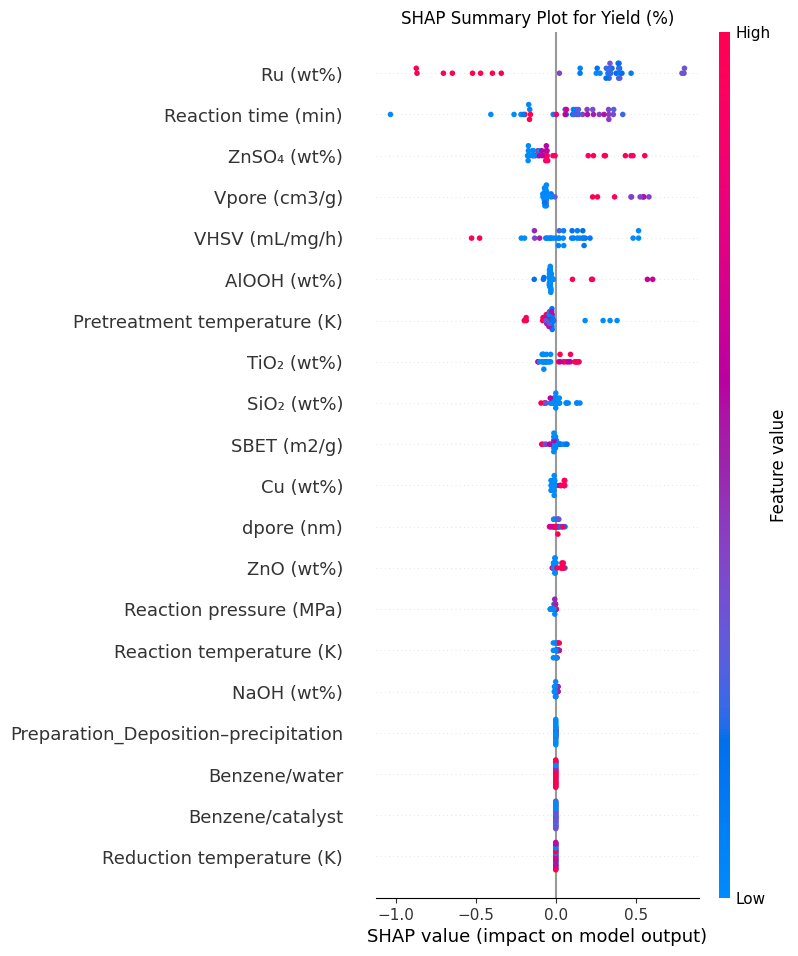


=== SHAP Analysis for Selectivity (%) ===


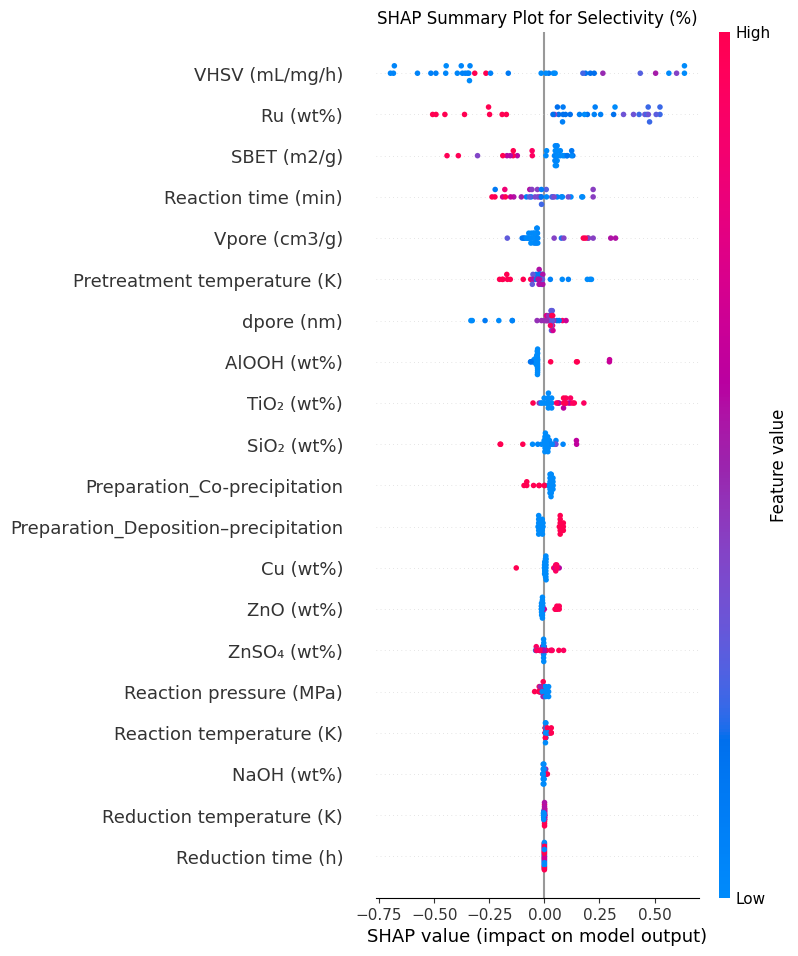


=== SHAP Analysis for Conversion (%) ===


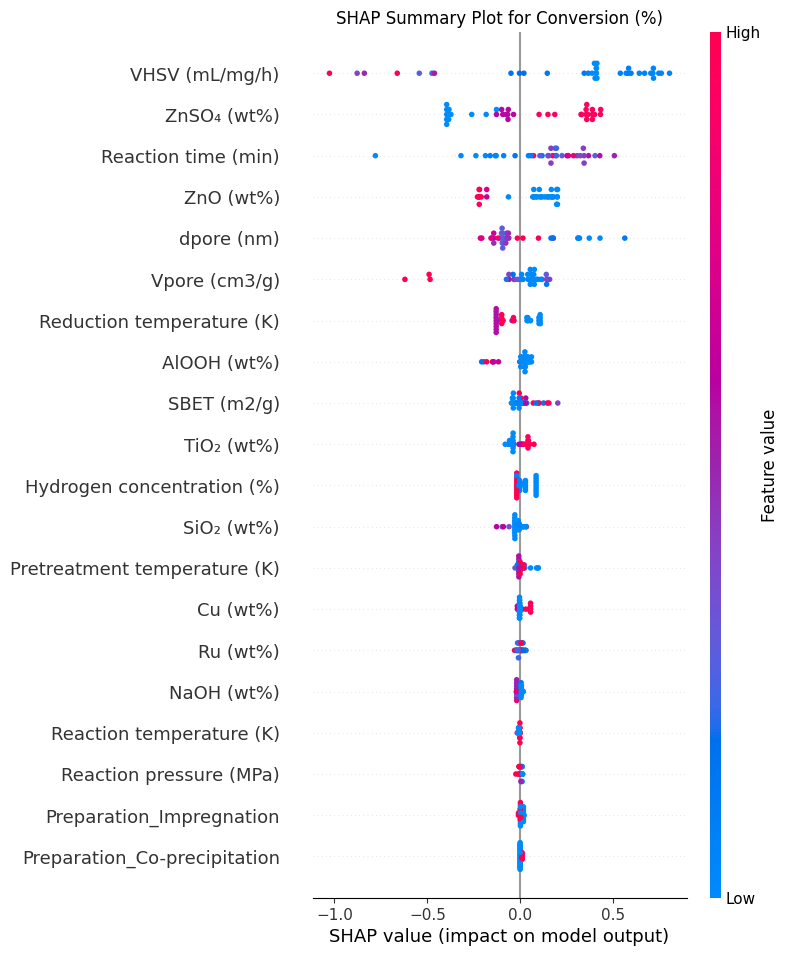

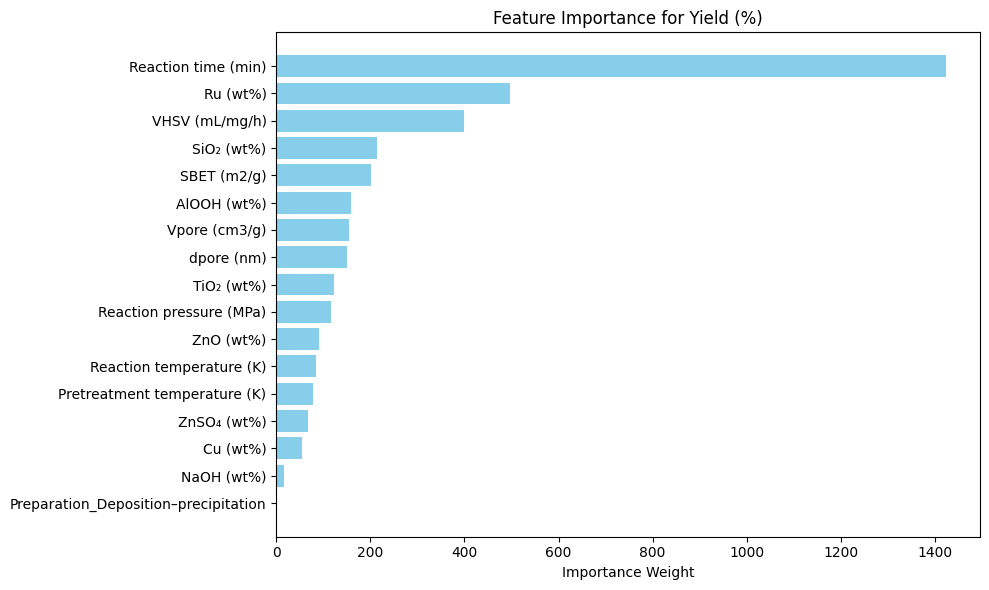

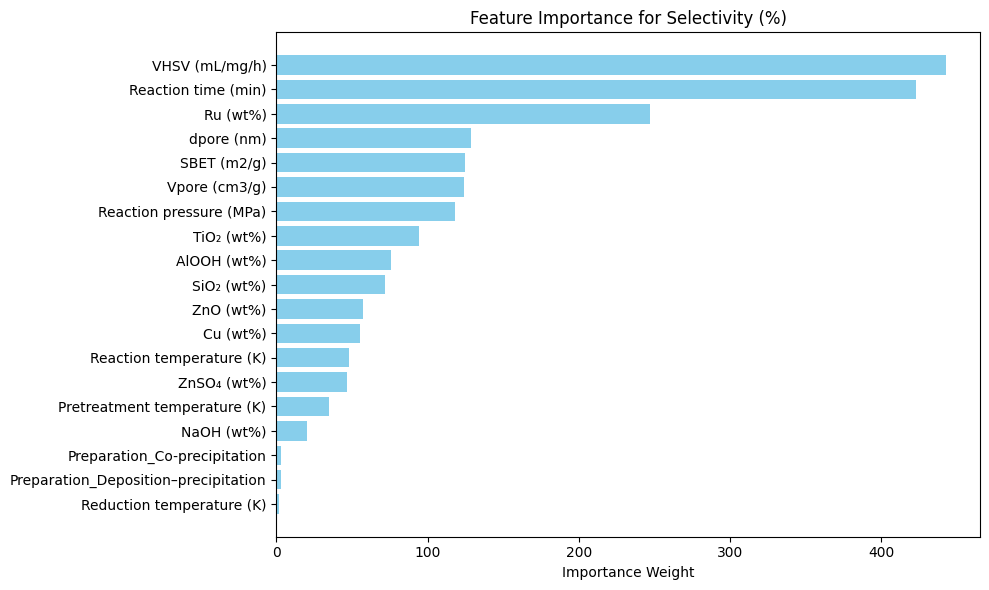

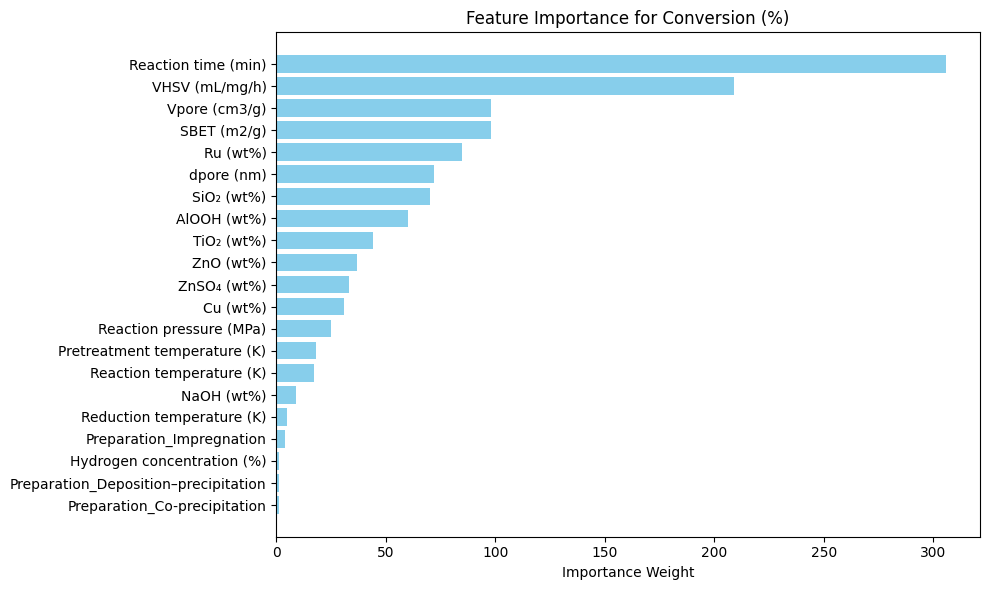

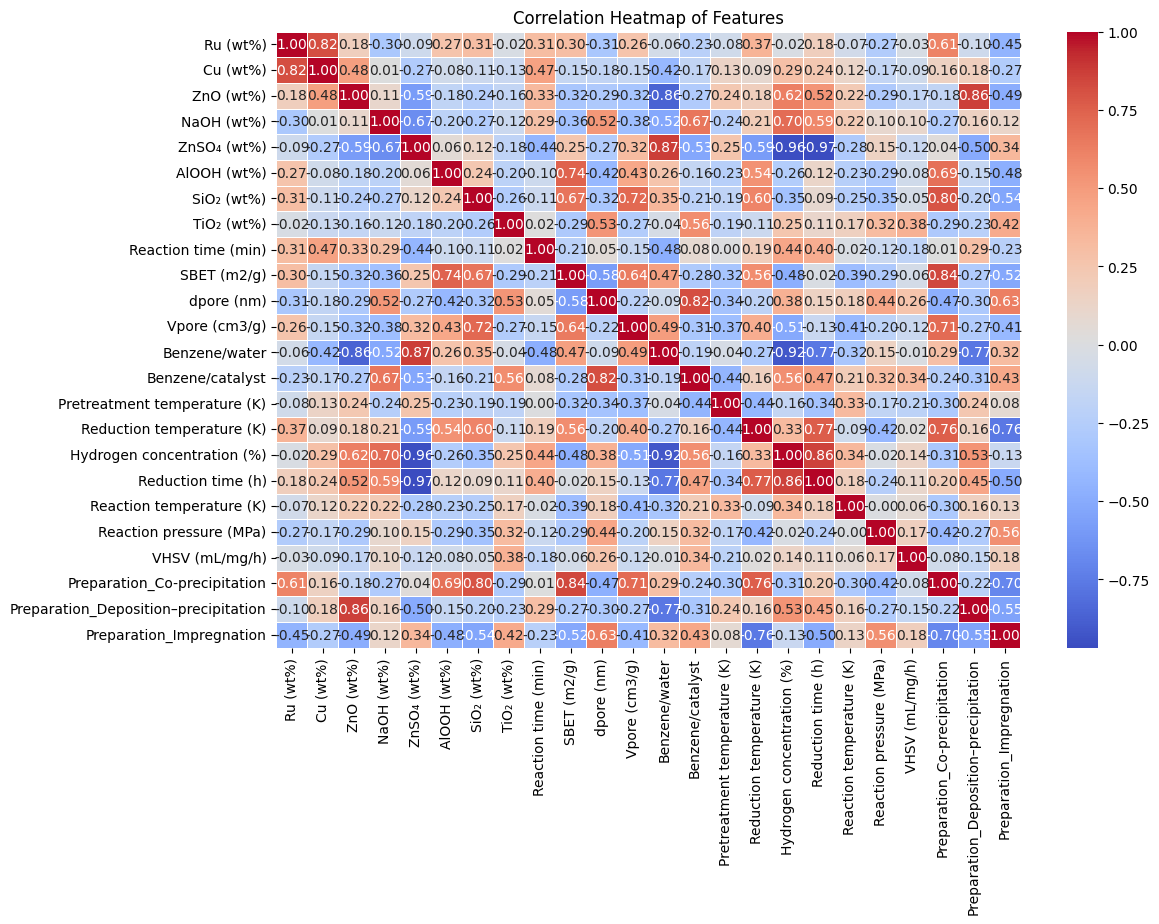

Top 20 samples by predicted Yield:
        Benzene/water  Benzene/catalyst  Pretreatment temperature (K)  \
831891          0.333          0.178303                    312.614614   
439904          0.175          0.132910                    313.966013   
333702          0.500          0.284690                    298.534730   
804639          0.500          0.190403                    314.140185   
410626          0.333          0.368335                    330.769922   
922004          0.175          0.141116                    307.101235   
545816          0.175          0.327447                    329.400595   
770761          0.175          0.057849                    313.027438   
747255          0.333          0.370768                    324.295690   
849045          0.175          0.352723                    298.200692   
485971          0.333          0.292833                    325.521430   
264282          0.500          0.213520                    309.331273   
864490          

In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns  # Import seaborn library for drawing heatmaps

# 1. Data Loading and Preprocessing
# Load the data
file_path = 'your dataset' # Print your dataset
df = pd.read_excel(file_path, sheet_name='Sheet1')

# View basic information of the data
print("First few rows of the original data:")
print(df.head())

# Fill missing values
imputer = SimpleImputer(strategy='mean')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric_imputed = imputer.fit_transform(df[numeric_columns])
df_imputed_combined = df.copy()
df_imputed_combined[numeric_columns] = df_numeric_imputed

# 1.1 One-hot encode the 'Preparation' column
df_imputed_combined = pd.get_dummies(df_imputed_combined, columns=['Preparation'], drop_first=False)
print("\nFirst few rows after one-hot encoding:")
print(df_imputed_combined.head())

# 1.2 Define feature columns for standardization and normalization
# Features to standardize
columns_to_standardize_features = [
    'Ru (wt%)', 'Cu (wt%)', 'ZnO (wt%)', 'NaOH (wt%)', 'ZnSO₄ (wt%)',
    'AlOOH (wt%)', 'SiO₂ (wt%)', 'TiO₂ (wt%)', 'Reaction time (min)',
    'SBET (m2/g)', 'dpore (nm)', 'Vpore (cm3/g)'
]

# Features to normalize
columns_to_normalize_features = [
    'Benzene/water', 'Benzene/catalyst', 'Pretreatment temperature (K)',
    'Reduction temperature (K)', 'Hydrogen concentration (%)', 'Reduction time (h)',
    'Reaction temperature (K)', 'Reaction pressure (MPa)', 'VHSV (mL/mg/h)'
]

# 2. Separate features and target variables
# Assume the targets are 'Yield (%)', 'Selectivity (%)', 'Conversion (%)'
target_columns = ["Yield (%)", "Selectivity (%)", "Conversion (%)"]
feature_columns = df_imputed_combined.columns.difference(target_columns)

X = df_imputed_combined[feature_columns]
y = df_imputed_combined[target_columns]

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Feature scaling
# 4.1 Standardize the designated features
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train[columns_to_standardize_features])
X_test_standard = scaler_standard.transform(X_test[columns_to_standardize_features])

# Convert standardized features to DataFrame
X_train_standard_df = pd.DataFrame(
    X_train_standard,
    columns=columns_to_standardize_features,
    index=X_train.index
)
X_test_standard_df = pd.DataFrame(
    X_test_standard,
    columns=columns_to_standardize_features,
    index=X_test.index
)

# 4.2 Normalize the designated features
scaler_minmax = MinMaxScaler()
X_train_normalized = scaler_minmax.fit_transform(X_train[columns_to_normalize_features])
X_test_normalized = scaler_minmax.transform(X_test[columns_to_normalize_features])

# Convert normalized features to DataFrame
X_train_normalized_df = pd.DataFrame(
    X_train_normalized,
    columns=columns_to_normalize_features,
    index=X_train.index
)
X_test_normalized_df = pd.DataFrame(
    X_test_normalized,
    columns=columns_to_normalize_features,
    index=X_test.index
)

# 4.3 Process other features (e.g., one-hot encoded columns)
other_features = X_train.drop(columns=columns_to_standardize_features + columns_to_normalize_features)

# 4.4 Combine all features into final training and testing sets
X_train_processed = pd.concat(
    [X_train_standard_df, X_train_normalized_df, other_features],
    axis=1
)
X_test_processed = pd.concat(
    [X_test_standard_df, X_test_normalized_df,
     X_test.drop(columns=columns_to_standardize_features + columns_to_normalize_features)],
    axis=1
)

# 4.5 Standardize the target variables using separate scalers
scalers_y = {target: StandardScaler() for target in target_columns}
y_train_scaled = pd.DataFrame(
    {target: scalers_y[target].fit_transform(y_train[[target]]).flatten()
     for target in target_columns},
    index=y_train.index
)
y_test_scaled = pd.DataFrame(
    {target: scalers_y[target].transform(y_test[[target]]).flatten()
     for target in target_columns},
    index=y_test.index
)

# 5. Model Training and Hyperparameter Tuning
# Define the XGBoost regression model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# 6. Use GridSearchCV for hyperparameter tuning and model training
# Train a separate model for each target variable
best_models = {}
best_params = {}
for target in target_columns:
    print(f"\nTuning hyperparameters and training for target '{target}'...")
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_processed, y_train_scaled[target])
    best_models[target] = grid_search.best_estimator_
    best_params[target] = grid_search.best_params_
    print(f"Best parameters for {target}: {grid_search.best_params_}")
    print(f"Best cross-validation R² for {target}: {grid_search.best_score_:.4f}")

# 7. Model Prediction
# Predict for each target variable
y_pred_scaled = {}
y_pred = {}
for target in target_columns:
    model = best_models[target]
    y_pred_scaled[target] = model.predict(X_test_processed)
    # Inverse-transform predictions
    y_pred[target] = scalers_y[target].inverse_transform(
        y_pred_scaled[target].reshape(-1, 1)
    ).flatten()


# 8. Compute Evaluation Metrics
# Calculate R², MAE, and RMSE for each target
for target in target_columns:
    r2 = r2_score(y_test[target], y_pred[target])
    mae = mean_absolute_error(y_test[target], y_pred[target])
    rmse = np.sqrt(mean_squared_error(y_test[target], y_pred[target]))
    print(f"\n=== {target} Prediction ===")
    print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# 9. Scatter Plots with Metrics in Corner
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, target in enumerate(target_columns):
    axes[i].scatter(y_test[target], y_pred[target], alpha=0.7, edgecolors='k')
    # Draw y = x reference line
    min_val = min(y_test[target].min(), y_pred[target].min())
    max_val = max(y_test[target].max(), y_pred[target].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[i].set_title(f"{target}: True vs Predicted")
    axes[i].set_xlabel(f"True {target}")
    axes[i].set_ylabel(f"Predicted {target}")

    # Add metrics text in top-left corner
    textstr = (f"R² = {r2_score(y_test[target], y_pred[target]):.2f}\n"
               f"MAE = {mean_absolute_error(y_test[target], y_pred[target]):.2f}\n"
               f"RMSE = {np.sqrt(mean_squared_error(y_test[target], y_pred[target])):.2f}")
    axes[i].text(
        0.05, 0.95,
        textstr,
        transform=axes[i].transAxes,
        fontsize=11,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.6)
    )

plt.tight_layout()
plt.show()

# 10. SHAP Analysis and Feature Importance

for i, target in enumerate(target_columns):
    print(f"\n=== SHAP Analysis for {target} ===")
    model = best_models[target]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_processed)

    # SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_processed, show=False)
    plt.title(f"SHAP Summary Plot for {target}")
    plt.show()

for target in target_columns:
    model = best_models[target]
    booster = model.get_booster()
    importance_dict = booster.get_score(importance_type="weight")

    # Convert to DataFrame and sort (ascending for horizontal bar plot)
    importance_df = pd.DataFrame({
        'Feature': list(importance_dict.keys()),
        'Importance': list(importance_dict.values())
    }).sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel("Importance Weight")
    plt.title(f"Feature Importance for {target}")
    plt.tight_layout()
    plt.show()


# 11. Correlation Heatmap
# Compute correlation matrix of features
correlation_matrix = X_train_processed.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# 12. Random Sample Generation and Prediction
n_samples = 1000000

# Generate random continuous variables (normalized and other features)
random_data = {
    'Benzene/water': np.random.choice([0.175, 0.333, 0.5], size=n_samples),
    'Benzene/catalyst': np.random.uniform(0.05, 0.3846, size=n_samples),
    'Pretreatment temperature (K)': np.random.uniform(298, 873, size=n_samples),
    'Reduction temperature (K)': np.random.uniform(298, 573, size=n_samples),
    'Hydrogen concentration (%)': np.random.choice([0, 5, 99.9], size=n_samples),
    'Reduction time (h)': np.random.choice([0,1,2,3], size=n_samples),
    'Reaction temperature (K)': np.random.uniform(373, 453, size=n_samples),
    'Reaction time (min)': np.random.uniform(1,60, size=n_samples),
    'Reaction pressure (MPa)': np.random.choice([2,3,4,5,6,7], size=n_samples),
    'SBET (m2/g)': np.random.uniform(8.4, 318, size=n_samples),
    'dpore (nm)': np.random.uniform(2.63, 42.2, size=n_samples),
    'Vpore (cm3/g)': np.random.uniform(0.03, 1.05, size=n_samples),
    'VHSV (mL/mg/h)': np.random.uniform(0.00058, 2, size=n_samples)
}

# Generate catalyst composition using Dirichlet to sum to 100
alpha = np.array([0.5, 0.5, 10, 10, 10, 10, 10, 10])
catalyst_compositions = np.random.dirichlet(alpha, size=n_samples) * 100

random_data['Ru (wt%)'] = catalyst_compositions[:, 0]
random_data['Cu (wt%)'] = catalyst_compositions[:, 1]
random_data['ZnO (wt%)'] = catalyst_compositions[:, 2]
random_data['NaOH (wt%)'] = catalyst_compositions[:, 3]
random_data['ZnSO₄ (wt%)'] = catalyst_compositions[:, 4]
random_data['AlOOH (wt%)'] = catalyst_compositions[:, 5]
random_data['SiO₂ (wt%)'] = catalyst_compositions[:, 6]
random_data['TiO₂ (wt%)'] = catalyst_compositions[:, 7]

# One-hot encode Preparation choices assumed to be ['Impregnation', 'Deposition–precipitation', 'Co-precipitation']
prep_choices = np.random.choice(
    ['Impregnation', 'Deposition–precipitation', 'Co-precipitation'],
    size=n_samples
)
prep_df = pd.get_dummies(prep_choices, prefix='Preparation')

# Combine all random data into DataFrame
df_random = pd.DataFrame(random_data)
df_random = pd.concat([df_random, prep_df], axis=1)

# Apply trained scalers to standardize and normalize
df_random_standard = pd.DataFrame(
    scaler_standard.transform(df_random[columns_to_standardize_features]),
    columns=columns_to_standardize_features
)
df_random_normalized = pd.DataFrame(
    scaler_minmax.transform(df_random[columns_to_normalize_features]),
    columns=columns_to_normalize_features
)
other_features = df_random.drop(columns=columns_to_standardize_features + columns_to_normalize_features)

df_random_processed = pd.concat([df_random_standard, df_random_normalized, other_features], axis=1)

# Predict Yield using the trained model
yield_pred_scaled = best_models["Yield (%)"].predict(df_random_processed)
yield_pred = scalers_y["Yield (%)"].inverse_transform(yield_pred_scaled.reshape(-1, 1)).flatten()

df_random_results = df_random.copy()
df_random_results['Yield_pred'] = yield_pred

# Show top 20 samples by predicted Yield
df_top20 = df_random_results.sort_values(by='Yield_pred', ascending=False).head(20)
print("Top 20 samples by predicted Yield:")
print(df_top20)

In [2]:
# Directly set feature values (modify these variables as needed)
Benzene_water = 0.5
Benzene_catalyst = 0.05
Pretreatment_temperature = 298
Reduction_temperature = 298
Hydrogen_concentration = 0
Reduction_time = 0
Reaction_temperature = 413
Reaction_time = 20
Reaction_pressure = 5
SBET = 50
dpore = 31
Vpore = 0.5
VHSV = 0.15     

# Catalyst composition percentages (ensure these sum to 100)
Ru = 1.61
Cu = 0
ZnO = 0
NaOH = 0
ZnSO4 = 84.88  
AlOOH = 0     
SiO2 = 0
TiO2 = 13.51

# The preparation method is determined as 'Impregnation'
Preparation_method = 'Impregnation'

# Organize manually input values into a dictionary
input_data = {
    'Benzene/water': Benzene_water,
    'Benzene/catalyst': Benzene_catalyst,
    'Pretreatment temperature (K)': Pretreatment_temperature,
    'Reduction temperature (K)': Reduction_temperature,
    'Hydrogen concentration (%)': Hydrogen_concentration,
    'Reduction time (h)': Reduction_time,
    'Reaction temperature (K)': Reaction_temperature,
    'Reaction time (min)': Reaction_time,
    'Reaction pressure (MPa)': Reaction_pressure,
    'SBET (m2/g)': SBET,
    'dpore (nm)': dpore,
    'Vpore (cm3/g)': Vpore,
    'VHSV (mL/mg/h)': VHSV,
    'Ru (wt%)': Ru,
    'Cu (wt%)': Cu,
    'ZnO (wt%)': ZnO,
    'NaOH (wt%)': NaOH,
    'ZnSO₄ (wt%)': ZnSO4,
    'AlOOH (wt%)': AlOOH,
    'SiO₂ (wt%)': SiO2,
    'TiO₂ (wt%)': TiO2
}

# Create a DataFrame to store the input data
df_input = pd.DataFrame(input_data, index=[0])

# Manually handle one-hot encoding for the Preparation method
prep_columns = [
    'Preparation_Co-precipitation',
    'Preparation_Deposition–precipitation',
    'Preparation_Impregnation'
]

# Ensure only one Preparation column is 1 and the others are 0
prep_df_input = pd.DataFrame(0, columns=prep_columns, index=[0])
prep_df_input['Preparation_Impregnation'] = 1  # because Preparation_method is 'Impregnation'

# Concatenate all input data
df_input_processed = pd.concat([df_input, prep_df_input], axis=1)

# Standardize and normalize the input features
df_input_standard = pd.DataFrame(
    scaler_standard.transform(df_input_processed[columns_to_standardize_features]),
    columns=columns_to_standardize_features
)
df_input_normalized = pd.DataFrame(
    scaler_minmax.transform(df_input_processed[columns_to_normalize_features]),
    columns=columns_to_normalize_features
)

# Add the remaining features (e.g., Preparation method) directly
df_input_processed_final = pd.concat(
    [df_input_standard, df_input_normalized, prep_df_input],
    axis=1
)

# Use the trained model to make a prediction
yield_pred_scaled_input = best_models["Yield (%)"].predict(df_input_processed_final)

# Inverse-transform to obtain predictions on the original scale
yield_pred_input = scalers_y["Yield (%)"].inverse_transform(
    yield_pred_scaled_input.reshape(-1, 1)
).flatten()

# Output the prediction result
print(f"Based on your input features, the predicted Yield is: {yield_pred_input[0]:.4f}")

Based on your input features, the predicted Yield is: 60.6036
